In [184]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import functools as ft

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [185]:
XY = np.loadtxt('dane.data')

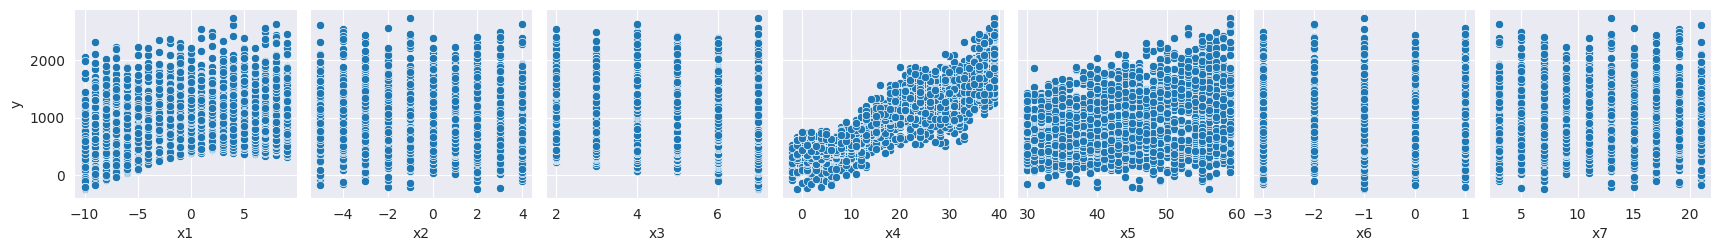

In [186]:
df = pd.DataFrame(data=XY, columns=['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'y'])
grid = sns.pairplot(df, x_vars=['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7'], y_vars=['y'])

<Axes: >

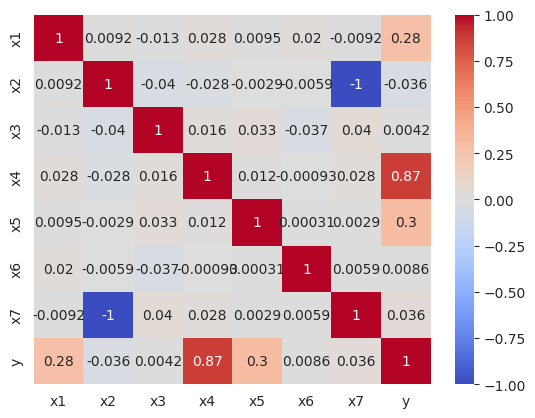

In [187]:
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

> x1, x4 i x5 układają się w jakąś prostą względem y \
> reszta danych pewnie potrzebuje jakichś transformacji (czym zajmiemy się później \
> x7 i x2 bardzo ciekawa korelacja

In [188]:
from utilz import divide_dataset

T = 10 # numer of iterations

# and some constants
EPOCHS = 3000
STEPS_TO_PLOT = 30
# STEPS_TO_PLOT should divide EPOCHS
EPSILON = 1e-5

datasets = []
for i in range(T):
    datasets.append(
        divide_dataset(
            XY.copy(),
            fractions_train_val_test=[0.6, 0.2, 0.2]))

> Mamy 10 losowych podziałów, tak żeby uśrednić wyniki

In [189]:
from utilz import run_linear_regression_model
from linear_regression import basic_analytic_linear_regression
from loss import ols

theta_Anal_NoIntercept_NotScaled, loss_Anal_NoIntercept_NotScaled, history_Anal_NoIntercept_NotScaled, training_Anal_NoIntercept_NotScaled =(
run_linear_regression_model(
    model=ft.partial(basic_analytic_linear_regression, intercept=False),
    loss=ols,
    datasets=datasets,
    standardize=False,
    use_test=False)
)

print(f"Avg theta [Anal_NoIntercept_NotScaled]:\n{theta_Anal_NoIntercept_NotScaled}")
print(f"Training loss [Anal_NoIntercept_NotScaled]: {training_Anal_NoIntercept_NotScaled}")
print(f"Validation loss [Anal_NoIntercept_NotScaled]: {history_Anal_NoIntercept_NotScaled}")
print(f"Test loss [Anal_NoIntercept_NotScaled]: {loss_Anal_NoIntercept_NotScaled}")

Avg theta [Anal_NoIntercept_NotScaled]:
[[  23.66481074]
 [-101.57214138]
 [  -6.4955352 ]
 [  39.05172156]
 [  18.73454601]
 [  -0.83903229]
 [ -49.51156464]]
Training loss [Anal_NoIntercept_NotScaled]: 14120.079625546303
Validation loss [Anal_NoIntercept_NotScaled]: 15464.280707360744
Test loss [Anal_NoIntercept_NotScaled]: 14883.71537524796


In [190]:
from utilz import run_linear_regression_model
from linear_regression import basic_analytic_linear_regression
from loss import ols

theta_Anal_Intercept_NotScaled, loss_Anal_Intercept_NotScaled, history_Anal_Intercept_NotScaled, training_Anal_Intercept_NotScaled =(
run_linear_regression_model(
    model=ft.partial(basic_analytic_linear_regression, intercept=True),
    loss=ols,
    datasets=datasets,
    standardize=False,
    use_test=False)
)

print(f"Avg theta [Anal_Intercept_NotScaled]:\n{theta_Anal_Intercept_NotScaled}")
print(f"Training loss [Anal_Intercept_NotScaled]: {training_Anal_Intercept_NotScaled}")
print(f"Validation loss [Anal_Intercept_NotScaled]: {history_Anal_Intercept_NotScaled}")
print(f"Test loss [Anal_Intercept_NotScaled]: {loss_Anal_Intercept_NotScaled}")

Avg theta [Anal_Intercept_NotScaled]:
[[-22.05725652]
 [ 23.66481074]
 [-97.5617311 ]
 [ -6.4955352 ]
 [ 39.05172156]
 [ 18.73454601]
 [ -0.83903229]
 [-47.5063595 ]]
Training loss [Anal_Intercept_NotScaled]: 14120.079625546303
Validation loss [Anal_Intercept_NotScaled]: 15464.280707360222
Test loss [Anal_Intercept_NotScaled]: 14883.715375247648


> Nie ma różnicy między intercept i bez interceptu \
> Być może ma to związek, z tym że x1, x4, i x5 przechodzą przez 0

> Szybko sprawdźmy ze SciKit-learn poprawność

In [191]:
from utilz import run_linear_regression_model
from sklearn.linear_model import LinearRegression
from loss import ols

model = LinearRegression(fit_intercept=False)
theta_SciKit_NoIntercept_NotScaled, loss_SciKit_NoIntercept_NotScaled, _, _ = run_linear_regression_model(
    model=lambda X, y, X_val, y_val:
        (model.fit(X, y).coef_.T, [], []),
    loss=ols,
    datasets=datasets,
    standardize=False,
    use_test=False)

model = LinearRegression(fit_intercept=True)
theta_SciKit_Intercept_NotScaled, loss_SciKit_Intercept_NotScaled, _, _ = run_linear_regression_model(
    model=lambda X, y, X_val, y_val:
        (np.c_[model.fit(X, y).intercept_, model.coef_].T, [], []),
    loss=ols,
    datasets=datasets,
    standardize=False,
    use_test=False)

In [192]:
print(f"Test loss [Anal_Intercept_NotScaled]: {loss_Anal_Intercept_NotScaled}")
print(f"Test loss [SciKit_Intercept_NotScaled]: {loss_SciKit_Intercept_NotScaled}")
print(f"Test loss [Anal_NoIntercept_NotScaled]: {loss_Anal_NoIntercept_NotScaled}")
print(f"Test loss [SciKit_NoIntercept_NotScaled]: {loss_SciKit_NoIntercept_NotScaled}")
print("-----------------------------")
print("Left: Analytic NotScaled, Right: SciKit NotScaled")
print("------------Intercept-------------")
print(np.hstack((theta_Anal_Intercept_NotScaled, theta_SciKit_Intercept_NotScaled)))
print("Left: Analytic NotScaled, Right: SciKit NotScaled")
print("-----------NoIntercept------------")
print(np.hstack((theta_Anal_NoIntercept_NotScaled, theta_SciKit_NoIntercept_NotScaled)))

Test loss [Anal_Intercept_NotScaled]: 14883.715375247648
Test loss [SciKit_Intercept_NotScaled]: 14883.715375247619
Test loss [Anal_NoIntercept_NotScaled]: 14883.71537524796
Test loss [SciKit_NoIntercept_NotScaled]: 14883.715375247597
-----------------------------
Left: Analytic NotScaled, Right: SciKit NotScaled
------------Intercept-------------
[[-2.20572565e+01 -5.55842864e+02]
 [ 2.36648107e+01  2.36648107e+01]
 [-9.75617311e+01 -5.09802419e-01]
 [-6.49553520e+00 -6.49553520e+00]
 [ 3.90517216e+01  3.90517216e+01]
 [ 1.87345460e+01  1.87345460e+01]
 [-8.39032286e-01 -8.39032286e-01]
 [-4.75063595e+01  1.01960484e+00]]
Left: Analytic NotScaled, Right: SciKit NotScaled
-----------NoIntercept------------
[[  23.66481074   23.66481074]
 [-101.57214138 -101.57214138]
 [  -6.4955352    -6.4955352 ]
 [  39.05172156   39.05172156]
 [  18.73454601   18.73454601]
 [  -0.83903229   -0.83903229]
 [ -49.51156464  -49.51156464]]


> Wygląda na to, że wszystko się zgadza \
> W dalszej części nie widzę sensu, żeby nie używać interceptu, więc będą rozważane tylko modele z interceptem \
> Okej, czas na gradient

In [193]:
from utilz import run_linear_regression_model
from linear_regression import GD_OLS_finite_difference_linear_regression
from linear_regression import GD_linear_regression
from gradient import GD_OLS
from loss import ols

theta_GD_FD_NotScaled, loss_GD_FD_NotScaled, _, _ =(
run_linear_regression_model(
    ft.partial(
        GD_OLS_finite_difference_linear_regression,
        alpha=0.0001,
        epochs=EPOCHS,
        epsilon=EPSILON),
    loss=ols,
    datasets=datasets,
    standardize=False,
    use_test=False)
)

theta_GD_NotScaled, loss_GD_NotScaled, history_GD_NotScaled, training_GD_NotScaled =(
run_linear_regression_model(
    ft.partial(
        GD_linear_regression,
        grad=GD_OLS,
        alpha=0.0001,
        epochs=EPOCHS,
        steps=STEPS_TO_PLOT,
        loss=ols),
    loss=ols,
    datasets=datasets,
    standardize=False,
    use_test=False)
)

In [194]:
print("Left: GD_FD NotScaled, Right: GD NotScaled")
print(np.hstack((theta_GD_FD_NotScaled, theta_GD_NotScaled)))


Left: GD_FD NotScaled, Right: GD NotScaled
[[ -4.16002305  -4.16002306]
 [ 23.99525669  23.99525669]
 [-17.34229611 -17.34229612]
 [-15.16429838 -15.16429836]
 [ 37.43039387  37.43039387]
 [ 11.36606135  11.36606135]
 [  2.18300526   2.18300526]
 [-11.07566144 -11.07566144]]


> Cieszymy się, potrafię liczyć gradient \
> Poszukajmy najlepszego parametru alpha
>
> [mała uwaga co do tego, jeśli da się alpha * 1/m to działa z sumą, inaczej eksplozja, co ma sens]

In [195]:
from utilz import search_alpha
from linear_regression import GD_linear_regression
from loss import ols
from gradient import GD_OLS

alphas = [0.000001, 0.00001, 0.0001, 0.001]
search_alpha(
    model=ft.partial(GD_linear_regression, grad=GD_OLS, epochs=EPOCHS),
    loss=ols,
    datasets=datasets,
    alphas=alphas,
    standardize=False)

Alpha: 1e-06, validation loss 57739.68566462274
Alpha: 1e-05, validation loss 19570.969641279014
Alpha: 0.0001, validation loss 16460.205993935866
Alpha: 0.001, validation loss nan


In [196]:
alphas = [0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009]
search_alpha(
    model=ft.partial(GD_linear_regression, grad=GD_OLS, epochs=EPOCHS),
    loss=ols,
    datasets=datasets,
    alphas=alphas,
    standardize=False)

Alpha: 0.0002, validation loss 15855.610853438866
Alpha: 0.0003, validation loss 15547.028333862221
Alpha: 0.0004, validation loss 15364.387745782045
Alpha: 0.0005, validation loss 15261.581814338491
Alpha: 0.0006, validation loss 15211.593399983676
Alpha: 0.0007, validation loss 15195.398506661679
Alpha: 0.0008, validation loss 1.489060659724989e+194
Alpha: 0.0009, validation loss nan


> Jak widzimy, alpha = 0.0007 daje najlepsze wyniki \
> Spójrzmy na learning curve

In [197]:
from utilz import run_linear_regression_model
from linear_regression import GD_linear_regression
from gradient import GD_OLS
from loss import ols

theta_GD_NotScaled, loss_GD_NotScaled, history_GD_NotScaled, training_GD_NotScaled =(
run_linear_regression_model(
    ft.partial(
        GD_linear_regression,
        grad=GD_OLS,
        alpha=0.0007,
        epochs=EPOCHS,
        steps=STEPS_TO_PLOT,
        loss=ols),
    loss=ols,
    datasets=datasets,
    standardize=False,
    use_test=False)
)

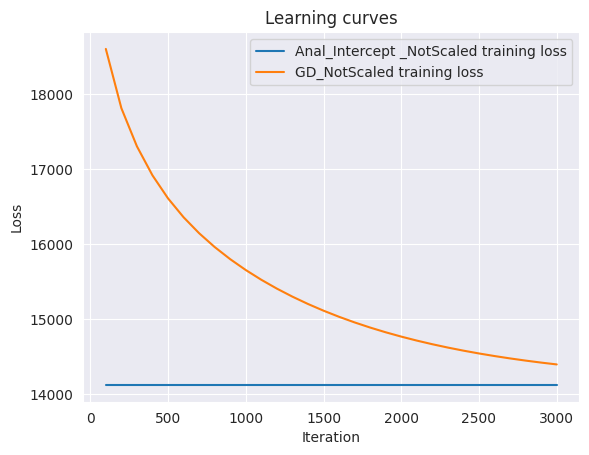

In [198]:
steps = np.arange(1, STEPS_TO_PLOT + 1) * (EPOCHS // STEPS_TO_PLOT)

fig, ax = plt.subplots()
sns.lineplot(x = steps, y = training_Anal_Intercept_NotScaled, ax = ax, label='Anal_Intercept _NotScaled training loss')
sns.lineplot(x = steps, y = training_GD_NotScaled, ax = ax, label='GD_NotScaled training loss')
ax.set(xlabel='Iteration', ylabel='Loss')
ax.set_title('Learning curves')
plt.legend()

> Jak się zaraz okaże, standaryzacja cech znacząco przyspiesza zbieżność

In [199]:
from utilz import search_alpha
from linear_regression import GD_linear_regression
from loss import ols
from gradient import GD_OLS

alphas = [0.0001, 0.001, 0.01, 0.1, 0.5, 1]
search_alpha(
    model=ft.partial(GD_linear_regression, grad=GD_OLS, epochs=EPOCHS),
    loss=ols,
    datasets=datasets,
    alphas=alphas,
    standardize=True)

Alpha: 0.0001, validation loss 335838.43686996785
Alpha: 0.001, validation loss 16942.634277634344
Alpha: 0.01, validation loss 15464.28070735973
Alpha: 0.1, validation loss 15464.280707360123
Alpha: 0.5, validation loss 15464.280707360125
Alpha: 1, validation loss 517976008.2309672


> No dobrze alpha = 0.1 i co z tego? Spójrzmy na learning curve

In [200]:
from utilz import run_linear_regression_model
from linear_regression import GD_linear_regression
from gradient import GD_OLS
from loss import ols

theta_GD_Scaled, loss_GD_Scaled, history_GD_Scaled, training_GD_Scaled =(
run_linear_regression_model(
    ft.partial(
        GD_linear_regression,
        grad=GD_OLS,
        alpha=0.1,
        epochs=EPOCHS,
        steps=STEPS_TO_PLOT,
        loss=ols),
    loss=ols,
    datasets=datasets,
    standardize=True,
    use_test=False)
)

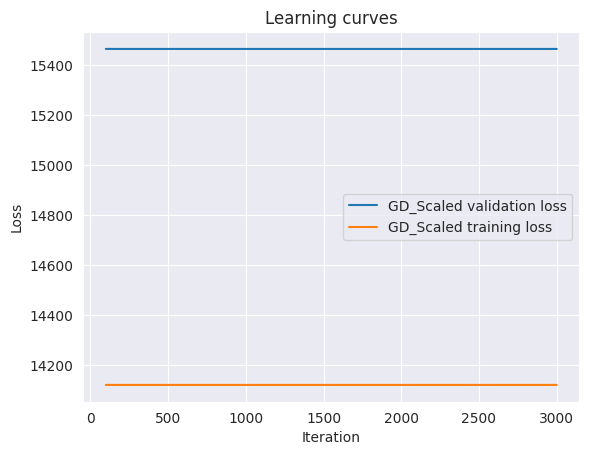

In [201]:
steps = np.arange(1, STEPS_TO_PLOT + 1) * (EPOCHS // STEPS_TO_PLOT)

fig, ax = plt.subplots()
sns.lineplot(x = steps, y = history_GD_Scaled, ax = ax, label='GD_Scaled validation loss')
sns.lineplot(x = steps, y = training_GD_Scaled, ax = ax, label='GD_Scaled training loss')
ax.set(xlabel='Iteration', ylabel='Loss')
ax.set_title('Learning curves')
plt.legend()

> Coś dziwnego prawda?

In [202]:
EPOCHS = 50
STEPS_TO_PLOT = 50

In [203]:
from utilz import run_linear_regression_model
from linear_regression import GD_linear_regression
from gradient import GD_OLS
from loss import ols

theta_GD_Scaled, loss_GD_Scaled, history_GD_Scaled, training_GD_Scaled =(
run_linear_regression_model(
    ft.partial(
        GD_linear_regression,
        grad=GD_OLS,
        alpha=0.1,
        epochs=EPOCHS,
        steps=STEPS_TO_PLOT,
        loss=ols),
    loss=ols,
    datasets=datasets,
    standardize=True,
    use_test=False)
)

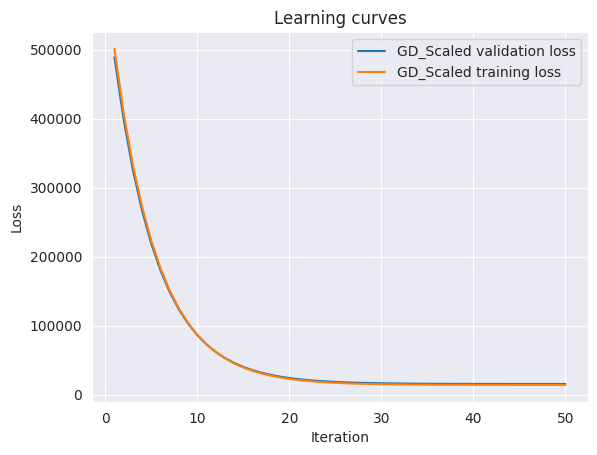

In [204]:
steps = np.arange(1, STEPS_TO_PLOT + 1) * (EPOCHS // STEPS_TO_PLOT)

fig, ax = plt.subplots()
sns.lineplot(x = steps, y = history_GD_Scaled, ax = ax, label='GD_Scaled validation loss')
sns.lineplot(x = steps, y = training_GD_Scaled, ax = ax, label='GD_Scaled training loss')
ax.set(xlabel='Iteration', ylabel='Loss')
ax.set_title('Learning curves')
plt.legend()

> Niesamowita zbieżność, bo gradient schodzi w każdą stronę równomiernie, dzięki standaryzacji

In [205]:
print(f"Validation loss [GD_Scaled]: {history_GD_Scaled[-1]}")
print(f"Validation loss [GD_NotScaled]: {history_GD_NotScaled[-1]}")
print("---------------------")
print(f"Training loss [GD_Scaled]: {training_GD_Scaled[-1]}")
print(f"Training loss [GD_NotScaled]: {training_GD_NotScaled[-1]}")

Validation loss [GD_Scaled]: 15485.943319131384
Validation loss [GD_NotScaled]: 15195.398506661677
---------------------
Training loss [GD_Scaled]: 14135.741947537124
Training loss [GD_NotScaled]: 14393.314003386175


> Czas na SGD <3

In [206]:
from utilz import run_linear_regression_model
from linear_regression import SGD_linear_regression
from gradient import GD_OLS
from loss import ols

theta_SGD_Scaled, loss_SGD_Scaled, history_SGD_Scaled, training_SGD_Scaled =(
run_linear_regression_model(
    ft.partial(
        SGD_linear_regression,
        grad=GD_OLS,
        alpha=0.1,
        batch_size=32,
        epochs=EPOCHS,
        steps=STEPS_TO_PLOT,
        loss=ols),
    loss=ols,
    datasets=datasets,
    standardize=True,
    use_test=False)
)

In [207]:
print(f"Test loss [GD_Scaled]: {loss_GD_Scaled}")
print(f"Test loss [SGD_Scaled]: {loss_SGD_Scaled}")
print("-----------------------------")
print("Left: GD Scaled, Right: SGD Scaled")
print(np.hstack((theta_GD_Scaled, theta_SGD_Scaled)))

Test loss [GD_Scaled]: 14853.682654575812
Test loss [SGD_Scaled]: 15041.257731101034
-----------------------------
Left: GD Scaled, Right: SGD Scaled
[[ 9.65254603e+02  9.70071423e+02]
 [ 1.34360496e+02  1.37337229e+02]
 [-3.63800740e+00 -5.46589533e-01]
 [-1.06833712e+01 -1.40320601e+01]
 [ 4.59362066e+02  4.57521228e+02]
 [ 1.61917035e+02  1.60830751e+02]
 [-1.15817774e+00  4.64008614e-01]
 [ 3.63800740e+00  5.46589533e-01]]


> Wygląda jakby miało działać \
> Poszukajmy hiperparametrów

In [208]:
from utilz import search_alpha
from linear_regression import SGD_linear_regression
from loss import ols
from gradient import GD_OLS

alphas = [0.0001, 0.001, 0.01, 0.1, 0.5, 1]
search_alpha(
    model=ft.partial(
        SGD_linear_regression,
        grad=GD_OLS,
        batch_size=32,
        epochs=EPOCHS),
    loss=ols,
    datasets=datasets,
    alphas=alphas,
    standardize=True)

Alpha: 0.0001, validation loss 414808.1277623578
Alpha: 0.001, validation loss 28530.447472488864
Alpha: 0.01, validation loss 15465.352812979501
Alpha: 0.1, validation loss 15575.811328351241
Alpha: 0.5, validation loss 18009.644356609213
Alpha: 1, validation loss 114696.06361233044


> Wygląda na to, że alpha = 0.01 jest najlepsze, dużo większe niż dla zwykłego gradientu... \
> Czy potrafimy to wytłumaczyć? \
> Być może dobieramy podzbiory, gdzie gradient jest większy

In [209]:
from utilz import search_batch_size
from linear_regression import SGD_linear_regression
from loss import ols
from gradient import GD_OLS

batch_sizes = [1, 16, 32, 64, 128, 256, 512]
search_batch_size(
    model=ft.partial(
        SGD_linear_regression,
        grad=GD_OLS,
        alpha=0.01,
        epochs=EPOCHS),
    loss=ols,
    datasets=datasets,
    batch_sizes=batch_sizes,
    standardize=True)

Batch size: 1, validation loss 16069.041970423603
Batch size: 16, validation loss 15470.831552313324
Batch size: 32, validation loss 15474.389027902624
Batch size: 64, validation loss 15468.559160469134
Batch size: 128, validation loss 15499.087474270742
Batch size: 256, validation loss 19340.74993113857
Batch size: 512, validation loss 44173.69851260181


> alpha = 0.01, batch_size = 64 \
> Popatrzmy na wykresiki

In [210]:
from utilz import run_linear_regression_model
from linear_regression import SGD_linear_regression
from gradient import GD_OLS
from loss import ols

theta_SGD_Scaled, loss_SGD_Scaled, history_SGD_Scaled, training_SGD_Scaled =(
run_linear_regression_model(
    ft.partial(
        SGD_linear_regression,
        grad=GD_OLS,
        alpha=0.01,
        batch_size=64,
        epochs=EPOCHS,
        steps=STEPS_TO_PLOT,
        loss=ols),
    loss=ols,
    datasets=datasets,
    standardize=True,
    use_test=False)
)

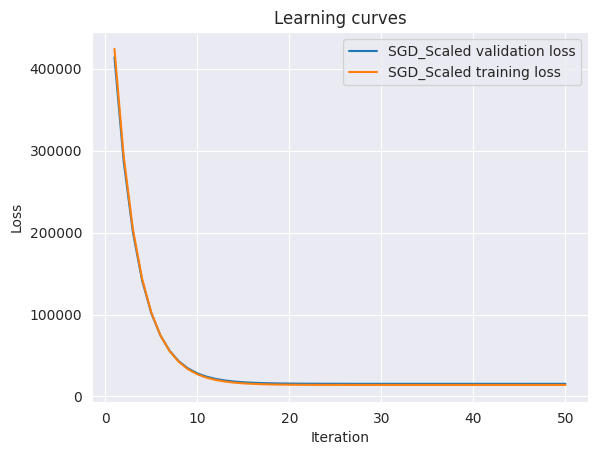

In [211]:
steps = np.arange(1, STEPS_TO_PLOT + 1) * (EPOCHS // STEPS_TO_PLOT)

fig, ax = plt.subplots()
sns.lineplot(x = steps, y = history_SGD_Scaled, ax = ax, label='SGD_Scaled validation loss')
sns.lineplot(x = steps, y = training_SGD_Scaled, ax = ax, label='SGD_Scaled training loss')
ax.set(xlabel='Iteration', ylabel='Loss')
ax.set_title('Learning curves')
plt.legend()

> Wydaje się, że zbiega szybciej niż GD

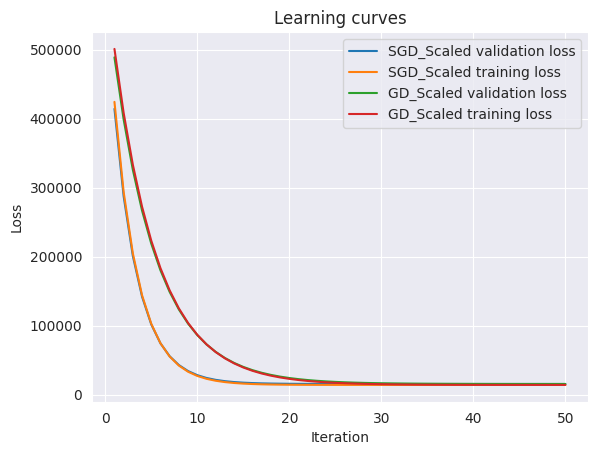

In [212]:
steps = np.arange(1, STEPS_TO_PLOT + 1) * (EPOCHS // STEPS_TO_PLOT)

fig, ax = plt.subplots()
sns.lineplot(x = steps, y = history_SGD_Scaled, ax = ax, label='SGD_Scaled validation loss')
sns.lineplot(x = steps, y = training_SGD_Scaled, ax = ax, label='SGD_Scaled training loss')
sns.lineplot(x = steps, y = history_GD_Scaled, ax = ax, label='GD_Scaled validation loss')
sns.lineplot(x = steps, y = training_GD_Scaled, ax = ax, label='GD_Scaled training loss')
ax.set(xlabel='Iteration', ylabel='Loss')
ax.set_title('Learning curves')
plt.legend()

> Możemy zerknąć już na test loss, nie będziemy ruszać tych modeli

In [213]:
print(f"Test loss [GD_Scaled]: {loss_GD_Scaled}")
print(f"Test loss [SGD_Scaled]: {loss_SGD_Scaled}")

Test loss [GD_Scaled]: 14853.682654575812
Test loss [SGD_Scaled]: 14886.037727361347


> Porównywalnie, musiało się gorzej wylosować, że się tak zdarzyło \
> Czas na regularyzacje, zostanę przy SGD, bo go bardzo lubię :) \
> Ale zanim SGD, przecież my umiemy rozwiązać to analitycznie

In [214]:
from utilz import run_linear_regression_model
from linear_regression import L2_analytic_linear_regression
from loss import ols

theta_Anal_L2, loss_Anal_L2, history_Anal_L2, training_Anal_L2 = run_linear_regression_model(
    model=ft.partial(L2_analytic_linear_regression,
               lambdaa=0.01,
               intercept=True,
               loss=ols),
    loss=ols,
    datasets=datasets,
    standardize=True,
    use_test=False)


> Ponownie użyjemy SciKit-learn, żeby sprawdzić

In [215]:
from sklearn.linear_model import Ridge
from loss import ols
from utilz import run_linear_regression_model

model = Ridge(alpha=0.01, fit_intercept=True)
theta_SciKit_L2, loss_SciKit_L2, _, _ = run_linear_regression_model(
    model=lambda X, y, X_val, y_val:
        (np.r_[model.fit(X, y).intercept_, model.coef_].reshape(-1, 1), [], []),
    loss=ols,
    datasets=datasets,
    standardize=True,
    use_test=False)


In [216]:
print(f"Test loss [Anal_L2]: {loss_Anal_L2}")
print(f"Test loss [SciKit_L2]: {loss_SciKit_L2}")
print("-----------------------------")
print("Left: L2 Analytic, Right: L2 SciKit")
print(np.hstack((theta_Anal_L2, theta_SciKit_L2)))

Test loss [Anal_L2]: 14883.572578363044
Test loss [SciKit_L2]: 14883.572578371048
-----------------------------
Left: L2 Analytic, Right: L2 SciKit
[[970.25507923 970.25507923]
 [134.63800082 134.63800082]
 [ -3.64809552  -3.64809551]
 [-10.98889822 -10.98889822]
 [461.68421833 461.68421833]
 [162.77215302 162.77215302]
 [ -1.20589995  -1.20589995]
 [  3.64809551   3.64809551]]


> Klasa, wszystko się zgadza, poszukajmy dobrej lambdy

In [217]:
from utilz import search_lambdas
from linear_regression import L2_analytic_linear_regression
from loss import ols

lambdas = [0, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1]
search_lambdas(
    model=ft.partial(
        L2_analytic_linear_regression,
        lambdaa=0.01,
        intercept=True,
        loss=ols),
    loss=ols,
    datasets=datasets,
    lambdas=lambdas,
    standardize=True)

Lambda: 0, validation loss 15464.280707360138
Lambda: 1e-05, validation loss 15464.280579995622
Lambda: 0.0001, validation loss 15464.27953133324
Lambda: 0.001, validation loss 15464.268929486894
Lambda: 0.01, validation loss 15464.162936301615
Lambda: 0.1, validation loss 15463.104001883656
Lambda: 1, validation loss 15452.614013490276


> Marginalne różnice, ale możemy sobie zobaczyć, czy otrzymamy ten sam wynik co zwykła regresja gdy lambda = 0

In [218]:
from utilz import run_linear_regression_model
from linear_regression import basic_analytic_linear_regression
from loss import ols

theta_Anal_Intercept_Scaled, loss_Anal_Intercept_Scaled, history_Anal_Intercept_Scaled, _ = (
    run_linear_regression_model(
    model=ft.partial(basic_analytic_linear_regression, intercept=True),
    loss=ols,
    datasets=datasets,
    standardize=True,
    use_test=False)
)

print(f"Val loss [Anal_Intercept_Scaled] {history_Anal_Intercept_Scaled}")

Val loss [Anal_Intercept_Scaled] 15464.280707360138


> Dokładnie to samo, cieszymy się \
> Możemy też zobaczyć czy norma thety się zmniejszy dla lambda = 1 \
> i przy okazji porównamy test loss, bo nic więcej się nie da zrobić

In [219]:
from utilz import run_linear_regression_model
from linear_regression import L2_analytic_linear_regression
from loss import ols

theta_Anal_L2, loss_Anal_L2, history_Anal_L2, training_Anal_L2 = run_linear_regression_model(
    model=ft.partial(L2_analytic_linear_regression,
               lambdaa=1,
               intercept=True,
               loss=ols),
    loss=ols,
    datasets=datasets,
    standardize=True,
    use_test=False)

In [220]:
print(f"Test loss [Anal_L2]: {loss_Anal_L2}")
print(f"Test loss [Anal_Intercept_Scaled]: {loss_Anal_Intercept_Scaled}")
print("-----------------------------")
print(f"Norm [Anal_L2]: {np.linalg.norm(theta_Anal_L2[1:])}")
print(f"Norm [Anal_Intercept_Scaled]: {np.linalg.norm(theta_Anal_Intercept_Scaled[1:])}")


Test loss [Anal_L2]: 14869.540343238823
Test loss [Anal_Intercept_Scaled]: 14883.715375247612
-----------------------------
Norm [Anal_L2]: 507.447560376791
Norm [Anal_Intercept_Scaled]: 507.86569124022213


> Powiedzmy, że wszystko się zgadza, chociaż różnice są marginalne

In [221]:
EPOCHS = 100
STEPS_TO_PLOT = 100
# for now, maybe L2 will need longer to converge

In [222]:
from utilz import search_alpha
from linear_regression import SGD_linear_regression
from loss import ols
from gradient import GD_OLS_L2

alphas = [0.00001, 0.0001, 0.001, 0.01]
search_alpha(
    model=ft.partial(
        SGD_linear_regression,
        grad=ft.partial(GD_OLS_L2, lambdaa=1),
        batch_size=64,
        epochs=EPOCHS),
    loss=ols,
    datasets=datasets,
    alphas=alphas,
    standardize=True)

Alpha: 1e-05, validation loss 69114.73435715337
Alpha: 0.0001, validation loss 15168.981825659906
Alpha: 0.001, validation loss 15187.66533919597
Alpha: 0.01, validation loss 16466.895941903516


In [223]:
from utilz import run_linear_regression_model
from linear_regression import SGD_linear_regression
from loss import ols
from gradient import GD_OLS_L2

theta_L2, loss_L2, history_L2, training_L2 = run_linear_regression_model(
    model=ft.partial(
        SGD_linear_regression,
        grad=ft.partial(GD_OLS_L2, lambdaa=1),
        alpha=0.001,
        epochs=EPOCHS,
        batch_size=64,
        steps=STEPS_TO_PLOT,
        loss=ols),
    loss=ols,
    datasets=datasets,
    standardize=True,
    use_test=False)

In [224]:
print(f"Val loss [L2]: {history_L2[-1]}")
print(f"Val loss [Anal_L2]: {history_Anal_L2[-1]}")
print(f"Norm [L2]: {np.linalg.norm(theta_L2[1:])}")

Val loss [L2]: 15184.672224995758
Val loss [Anal_L2]: 15452.614013490276
Norm [L2]: 492.05514297329637


> Znowu SGD pozytywnie zaskakuje \
> Zobaczmy wykres

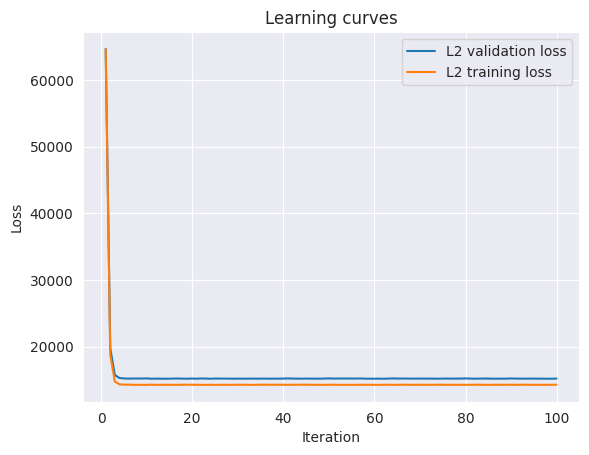

In [225]:
steps = np.arange(1, STEPS_TO_PLOT + 1) * (EPOCHS // STEPS_TO_PLOT)

fig, ax = plt.subplots()
sns.lineplot(x = steps, y = history_L2, ax = ax, label='L2 validation loss')
sns.lineplot(x = steps, y = training_L2, ax = ax, label='L2 training loss')
ax.set(xlabel='Iteration', ylabel='Loss')
ax.set_title('Learning curves')
plt.legend()

> Mieszane uczucia co do tego SGD + L2 \
> Było, żle konieczna tam jest np.sum a nie np.mean w gradiencie, inną wagę ma wtedy norma \
> Zróbmy lasso, liczę, że wyzeruje nieistotne cechy

In [226]:
EPOCHS = 100
STEPS_TO_PLOT = 100
# for now, maybe L1 will need longer to converge

In [227]:
from utilz import run_linear_regression_model
from linear_regression import L1_linear_regression
from loss import ols

theta_L1, loss_L1, history_L1, training_L1 = run_linear_regression_model(
    model=ft.partial(
        L1_linear_regression,
        lambdaa=0.1,
        epochs=EPOCHS,
        intercept=True,
        steps=STEPS_TO_PLOT,
        loss=ols),
    loss=ols,
    datasets=datasets,
    standardize=True,
    use_test=False)

In [228]:
print(f"Avg theta [L1]:\n{theta_L1}")
print(f"Val loss [L1]: {history_L1[-1]}")


Avg theta [L1]:
[[970.25507923]
 [134.63896566]
 [ -5.94743735]
 [-10.98901163]
 [461.6880045 ]
 [162.77346861]
 [ -1.20588038]
 [  1.34874315]]
Val loss [L1]: 15464.278701744715


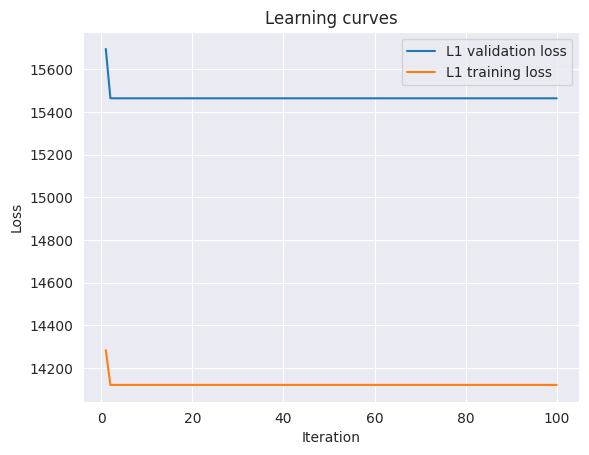

In [229]:
steps = np.arange(1, STEPS_TO_PLOT + 1) * (EPOCHS // STEPS_TO_PLOT)

fig, ax = plt.subplots()
sns.lineplot(x = steps, y = history_L1, ax = ax, label='L1 validation loss')
sns.lineplot(x = steps, y = training_L1, ax = ax, label='L1 training loss')
ax.set(xlabel='Iteration', ylabel='Loss')
ax.set_title('Learning curves')
plt.legend()

> Coś mi tu nie pasuje, zobaczmy SciKit

In [230]:
from sklearn.linear_model import Lasso
from loss import ols
from utilz import run_linear_regression_model

model = Lasso(alpha=0.1, fit_intercept=True)
theta_SciKit_L1, loss_SciKit_L1, _, _ = run_linear_regression_model(
    model=lambda X, y, X_val, y_val:
        (np.r_[model.fit(X, y).intercept_, model.coef_].reshape(-1, 1), [], []),
    loss=ols,
    datasets=datasets,
    standardize=True,
    use_test=False)


In [231]:
print("Left: L1 SGD, Right: L1 SciKit")
print(np.hstack((theta_L1, theta_SciKit_L1)))


Left: L1 SGD, Right: L1 SciKit
[[970.25507923 970.25507923]
 [134.63896566 134.54497867]
 [ -5.94743735  -5.84853093]
 [-10.98901163 -10.88104508]
 [461.6880045  461.58797461]
 [162.77346861 162.67380499]
 [ -1.20588038  -1.10272597]
 [  1.34874315   1.34379076]]


> Zadziwiająco szybko zbiega \
> Potwierdza się hipoteza, że L1 wskaże istotne cechy \
> Poszukajmy jeszcze lambdy

In [232]:
from utilz import search_lambdas
from linear_regression import L1_linear_regression
from loss import ols

lambdas = [0, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 2, 4, 8, 16, 256]
search_lambdas(
    model=ft.partial(
        L1_linear_regression,
        epochs=EPOCHS,
        intercept=True,
        steps=STEPS_TO_PLOT,
        loss=ols),
    loss=ols,
    datasets=datasets,
    lambdas=lambdas,
    standardize=True)

Lambda: 0, validation loss 15464.280707360118
Lambda: 1e-05, validation loss 15464.280707159563
Lambda: 0.0001, validation loss 15464.2807053545
Lambda: 0.001, validation loss 15464.280687303897
Lambda: 0.01, validation loss 15464.280506798099
Lambda: 0.1, validation loss 15464.278701744715
Lambda: 1, validation loss 15464.26065169111
Lambda: 2, validation loss 15464.240597099797
Lambda: 4, validation loss 15464.200491150365
Lambda: 8, validation loss 15464.120292183947
Lambda: 16, validation loss 15463.959945981205
Lambda: 256, validation loss 15459.18163254275


> Interesujące, że bardzo duże lambdy dobrze uogólniają

In [233]:
from utilz import run_linear_regression_model
from linear_regression import L1_linear_regression
from loss import ols

theta_L1, loss_L1, history_L1, training_L1 = run_linear_regression_model(
    model=ft.partial(
        L1_linear_regression,
        lambdaa=256,
        epochs=EPOCHS,
        intercept=True,
        steps=STEPS_TO_PLOT,
        loss=ols),
    loss=ols,
    datasets=datasets,
    standardize=True,
    use_test=False)

print(f"Val loss [L1]: {history_L1[-1]}")
print(f"Training loss [L1]: {training_L1[-1]}")
print(f"Test loss [L1]: {loss_L1}")
print("------------------------------")
print(f"Training loss [L2]: {training_L2[-1]}")
print(f"Test loss [L2]: {loss_L2}")

Val loss [L1]: 15459.18163254275
Training loss [L1]: 14120.114324293605
Test loss [L1]: 14876.476457945691
------------------------------
Training loss [L2]: 14265.164739978258
Test loss [L2]: 14499.908290487812


> Zostawmy to na chwilę i zajmijmy się siecią elastyczna

In [234]:
from utilz import run_linear_regression_model
from linear_regression import ElasticNet_linear_regression
from loss import ols

theta_E, loss_E, history_E, training_E = run_linear_regression_model(
    model=ft.partial(
        ElasticNet_linear_regression,
        lambdaa=256,
        alpha=0,
        epochs=EPOCHS,
        intercept=True,
        steps=STEPS_TO_PLOT,
        loss=ols),
    loss=ols,
    datasets=datasets,
    standardize=True,
    use_test=False)

> Możemy sprawdzić, czy to działa, dając alpha = 1 i alpha = 0

In [235]:
print("Left: L1 SGD, Right: ElasticNet")
print(np.hstack((theta_L1, theta_E)))

Left: L1 SGD, Right: ElasticNet
[[970.25507923 970.25507923]
 [134.53861321 134.53861321]
 [ -5.84184654  -5.84184654]
 [-10.87375138 -10.87375138]
 [461.58121459 461.58121459]
 [162.66706966 162.66706966]
 [ -1.09575431  -1.09575431]
 [  1.34345616   1.34345616]]


In [236]:
from utilz import run_linear_regression_model
from linear_regression import ElasticNet_linear_regression
from loss import ols

theta_E, loss_E, history_E, training_E = run_linear_regression_model(
    model=ft.partial(
        ElasticNet_linear_regression,
        lambdaa=1,
        alpha=1,
        epochs=EPOCHS,
        intercept=True,
        steps=STEPS_TO_PLOT,
        loss=ols),
    loss=ols,
    datasets=datasets,
    standardize=True,
    use_test=False)

In [237]:
print("Left: L2 SGD, Right: ElasticNet")
print(np.hstack((theta_L2, theta_E)))

Left: L2 SGD, Right: ElasticNet
[[970.04788132 970.25507923]
 [130.37687884 134.53865524]
 [ -3.71039672  -5.59392802]
 [-10.94312747 -10.97317492]
 [447.7215024  461.3055666 ]
 [156.57667149 162.63790673]
 [ -1.43153668  -1.20356014]
 [  3.71039672   1.70063804]]


> Powiedziałbym, że działa, różnice pewnie wynikają z użycia SGD \
> Załóżmy, że lambdy powinny być raczej większe, poszukajmy dobrej alphy

In [238]:
from utilz import search_alpha
from linear_regression import ElasticNet_linear_regression
from loss import ols

alphas = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
search_alpha(
    model=ft.partial(
        ElasticNet_linear_regression,
        intercept=True,
        lambdaa=1,
        epochs=EPOCHS,
        loss=ols,
        steps=STEPS_TO_PLOT),
    loss=ols,
    datasets=datasets,
    alphas=alphas,
    standardize=True)

Alpha: 0, validation loss 15464.26065169111
Alpha: 0.1, validation loss 15463.087672534068
Alpha: 0.2, validation loss 15461.916863249333
Alpha: 0.3, validation loss 15460.74822420975
Alpha: 0.4, validation loss 15459.581755756595
Alpha: 0.5, validation loss 15458.417458200367
Alpha: 0.6, validation loss 15457.25533182139
Alpha: 0.7, validation loss 15456.095376870482
Alpha: 0.8, validation loss 15454.937593569624
Alpha: 0.9, validation loss 15453.78198211242
Alpha: 1, validation loss 15452.628542664965


> Tendencja do tego, że L2 lepiej działa

In [239]:
from utilz import run_linear_regression_model
from linear_regression import ElasticNet_linear_regression
from loss import ols

theta_E, loss_E, history_E, training_E = run_linear_regression_model(
    model=ft.partial(
        ElasticNet_linear_regression,
        lambdaa=1,
        alpha=1,
        epochs=EPOCHS,
        intercept=True,
        steps=STEPS_TO_PLOT,
        loss=ols),
    loss=ols,
    datasets=datasets,
    standardize=True,
    use_test=False)

In [240]:
print(f"Test loss [ElasticNet]: {loss_E}")
print(f"Test loss [L2]: {loss_L2}")
print(f"Test loss [L1]: {loss_L1}")
print(f"Test loss [SGD]: {loss_SGD_Scaled}")

Test loss [ElasticNet]: 14869.522660821585
Test loss [L2]: 14499.908290487812
Test loss [L1]: 14876.476457945691
Test loss [SGD]: 14886.037727361347


> Rzeczywiście L2 króluje \
> Teraz wykresy, jak przebiega uczenie od rozmiaru zbioru treningowego

In [241]:
from utilz import learning_curve
from linear_regression import SGD_linear_regression
from gradient import GD_OLS
from loss import ols
training_set_fraction = [0.01, 0.02, 0.03, 0.125, 0.625, 1]

SGD_frac_training_loss, SGD_frac_test_loss = learning_curve(
    model=ft.partial(
        SGD_linear_regression,
        grad=GD_OLS,
        alpha=0.01,
        batch_size=64,
        epochs=EPOCHS,
        steps=1,
        loss=ols),
    loss=ols,
    datasets=datasets,
    training_set_fractions=training_set_fraction)

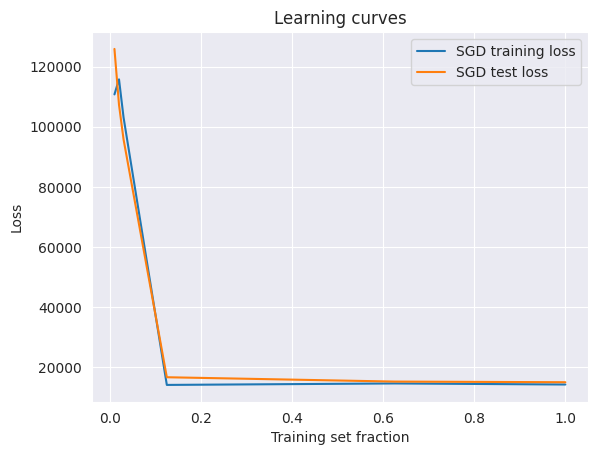

In [242]:
fig, ax = plt.subplots()
sns.lineplot(x = training_set_fraction, y = SGD_frac_training_loss, ax = ax, label='SGD training loss')
sns.lineplot(x = training_set_fraction, y = SGD_frac_test_loss, ax = ax, label='SGD test loss')
ax.set(xlabel='Training set fraction', ylabel='Loss')
ax.set_title('Learning curves')
plt.legend()

> Zbiega szybko \
> Zmniejszmy alpha i zobaczmy co się stanie, może będzie bardziej gładko

In [243]:
from utilz import learning_curve
from linear_regression import SGD_linear_regression
from gradient import GD_OLS
from loss import ols
training_set_fraction = [0.01, 0.02, 0.03, 0.125, 0.625, 1]

SGD_frac_training_loss_slow, SGD_frac_test_loss_slow = learning_curve(
    model=ft.partial(
        SGD_linear_regression,
        grad=GD_OLS,
        alpha=0.001,
        batch_size=64,
        epochs=EPOCHS,
        steps=1,
        loss=ols),
    loss=ols,
    datasets=datasets,
    training_set_fractions=training_set_fraction)

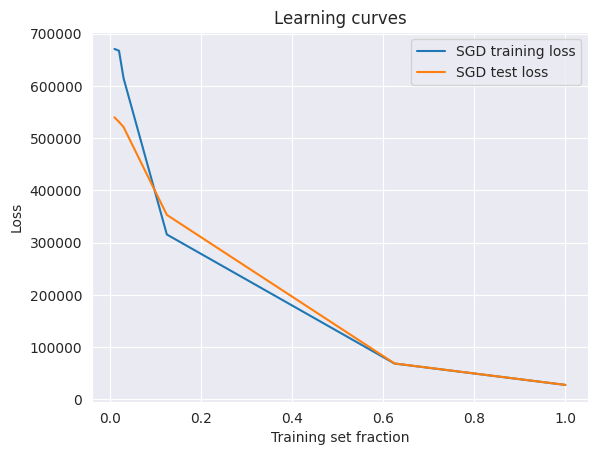

In [244]:
fig, ax = plt.subplots()
sns.lineplot(x = training_set_fraction, y = SGD_frac_training_loss_slow, ax = ax, label='SGD training loss')
sns.lineplot(x = training_set_fraction, y = SGD_frac_test_loss_slow, ax = ax, label='SGD test loss')
ax.set(xlabel='Training set fraction', ylabel='Loss')
ax.set_title('Learning curves')
plt.legend()

> Jeszcze nałóżmy na siebie te wykresy

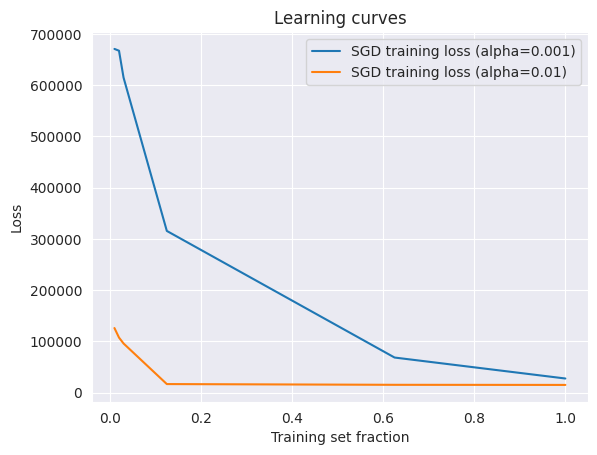

In [245]:
fig, ax = plt.subplots()
sns.lineplot(x = training_set_fraction, y = SGD_frac_training_loss_slow, ax = ax, label='SGD training loss (alpha=0.001)')
sns.lineplot(x = training_set_fraction, y = SGD_frac_test_loss, ax = ax, label='SGD training loss (alpha=0.01)')
ax.set(xlabel='Training set fraction', ylabel='Loss')
ax.set_title('Learning curves')
plt.legend()

> Ładny wykresik, jeszcze L2 mnie ciekawi

In [246]:
from utilz import learning_curve
from linear_regression import SGD_linear_regression
from gradient import GD_OLS_L2
from loss import ols
training_set_fraction = [0.01, 0.02, 0.03, 0.125, 0.625, 1]

L2_frac_training_loss, L2_frac_test_loss = learning_curve(
    model=ft.partial(
        SGD_linear_regression,
        grad=ft.partial(GD_OLS_L2, lambdaa=1),
        alpha=0.001,
        epochs=EPOCHS,
        batch_size=64,
        steps=1,
        loss=ols),
    loss=ols,
    datasets=datasets,
    training_set_fractions=training_set_fraction)

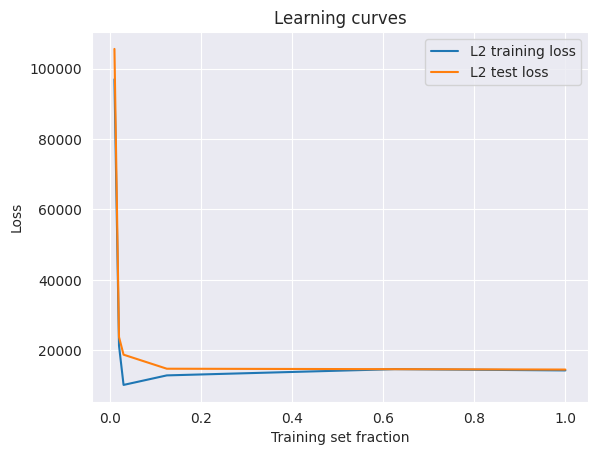

In [247]:
fig, ax = plt.subplots()
sns.lineplot(x = training_set_fraction, y = L2_frac_training_loss, ax = ax, label='L2 training loss')
sns.lineplot(x = training_set_fraction, y = L2_frac_test_loss, ax = ax, label='L2 test loss')
ax.set(xlabel='Training set fraction', ylabel='Loss')
ax.set_title('Learning curves')
plt.legend()

> Wygląda jakby się dopasował i potem zaczął regularyzować \
> Co się stanie jak pobawimy się parametrami?

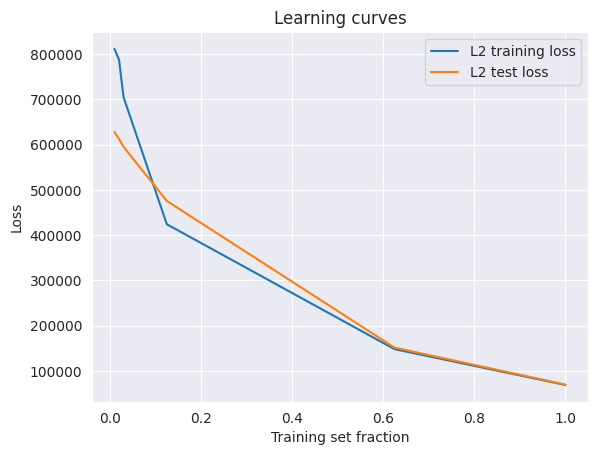

In [248]:
from utilz import learning_curve
from linear_regression import SGD_linear_regression
from gradient import GD_OLS_L2
from loss import ols
training_set_fraction = [0.01, 0.02, 0.03, 0.125, 0.625, 1]

L2_frac_training_loss, L2_frac_test_loss = learning_curve(
    model=ft.partial(
        SGD_linear_regression,
        grad=ft.partial(GD_OLS_L2, lambdaa=1),
        alpha=0.00001,
        epochs=EPOCHS,
        batch_size=64,
        steps=1,
        loss=ols),
    loss=ols,
    datasets=datasets,
    training_set_fractions=training_set_fraction)

fig, ax = plt.subplots()
sns.lineplot(x = training_set_fraction, y = L2_frac_training_loss, ax = ax, label='L2 training loss')
sns.lineplot(x = training_set_fraction, y = L2_frac_test_loss, ax = ax, label='L2 test loss')
ax.set(xlabel='Training set fraction', ylabel='Loss')
ax.set_title('Learning curves')
plt.legend()

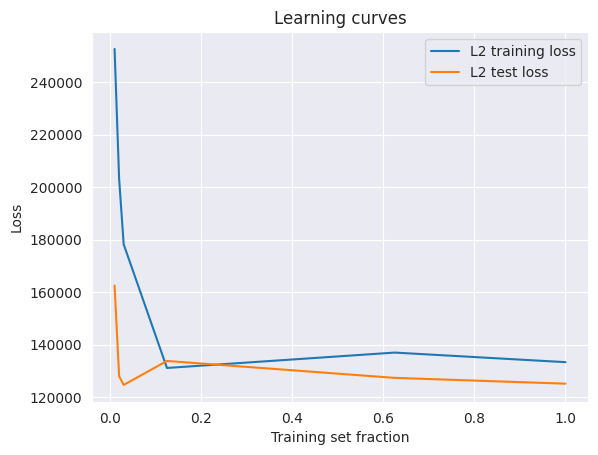

In [249]:
from utilz import learning_curve
from linear_regression import SGD_linear_regression
from gradient import GD_OLS_L2
from loss import ols
training_set_fraction = [0.01, 0.02, 0.03, 0.125, 0.625, 1]

L2_frac_training_loss, L2_frac_test_loss = learning_curve(
    model=ft.partial(
        SGD_linear_regression,
        grad=ft.partial(GD_OLS_L2, lambdaa=512),
        alpha=0.001,
        epochs=EPOCHS,
        batch_size=64,
        steps=1,
        loss=ols),
    loss=ols,
    datasets=datasets,
    training_set_fractions=training_set_fraction)

fig, ax = plt.subplots()
sns.lineplot(x = training_set_fraction, y = L2_frac_training_loss, ax = ax, label='L2 training loss')
sns.lineplot(x = training_set_fraction, y = L2_frac_test_loss, ax = ax, label='L2 test loss')
ax.set(xlabel='Training set fraction', ylabel='Loss')
ax.set_title('Learning curves')
plt.legend()

> Silna regularyzacja \
> I na sam koniec zabawa funkcjami bazowymi \
> Nie do końca wiem, czy mogę patrzeć na wszystkie dane \
> Z jednej strony to trochę oszustwo \
> A z drugiej strony i tak ich używam do uczenia wybierając T podziałów \
> Więc popatrzę na wszystkie \
> x1, x4 i x5 zostawiam w spokoju

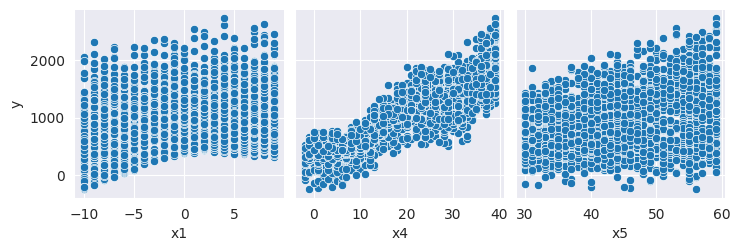

In [250]:
XY_copy = XY.copy()

df = pd.DataFrame(data=XY_copy, columns=['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'y'])
grid = sns.pairplot(df, x_vars=['x1', 'x4', 'x5'], y_vars=['y'])

<Axes: >

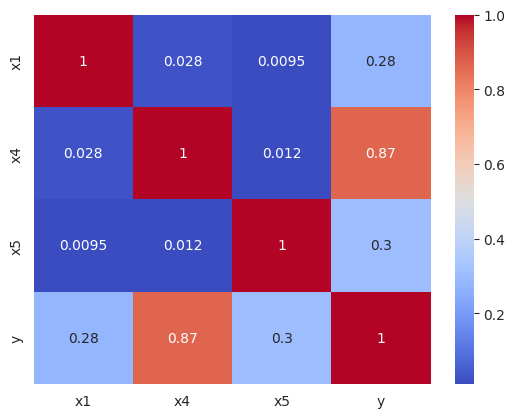

In [251]:
df.drop(inplace=True, columns=['x2', 'x3', 'x6', 'x7'])
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

In [252]:
XY_copy = XY.copy()

columns_to_transform = [1, 2, 5, 6]
last_column = XY_copy[:, -1].reshape(-1, 1)

X_selected = XY_copy[:, columns_to_transform]

polynomial_features = [X_selected]
for degree in range(2, 5):
    polynomial_features.append(X_selected ** degree)
polynomial_features = np.hstack(polynomial_features)

sigmoid_features = 1 / (1 + np.exp(-X_selected))
transformed_features = np.hstack([polynomial_features, sigmoid_features])

XY_aug  = np.hstack([transformed_features, last_column])

<Axes: >

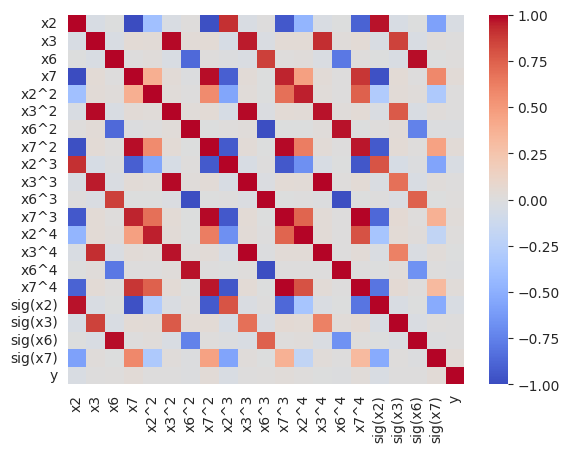

In [253]:
df = pd.DataFrame(data=XY_aug, columns=[
    'x2', 'x3', 'x6', 'x7',
    'x2^2', 'x3^2', 'x6^2', 'x7^2',
    'x2^3', 'x3^3', 'x6^3', 'x7^3',
    'x2^4', 'x3^4', 'x6^4', 'x7^4',
    'sig(x2)', 'sig(x3)', 'sig(x6)', 'sig(x7)',
    'y'])
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm')

> Brak jakiejkolwiek korelacji

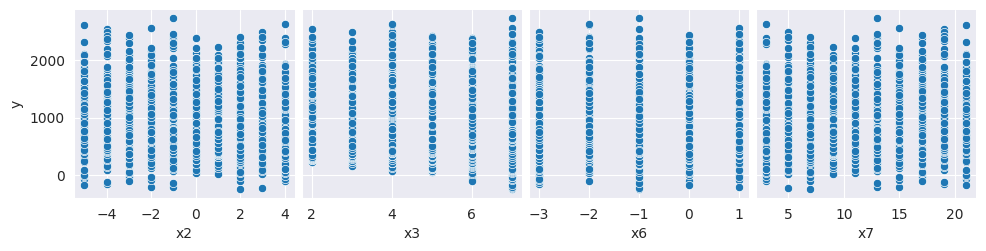

In [254]:
grid = sns.pairplot(df, x_vars=['x2', 'x3', 'x6', 'x7'], y_vars=['y'])

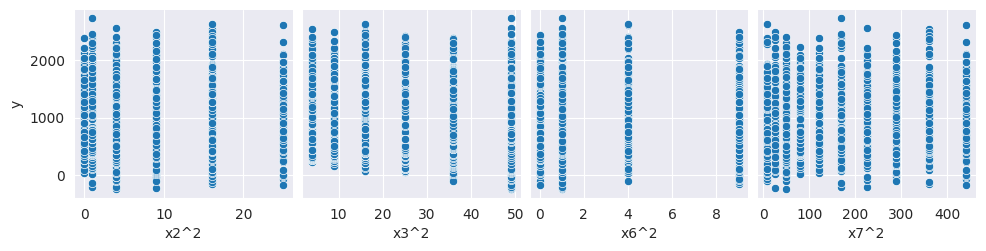

In [255]:
grid = sns.pairplot(df, x_vars=['x2^2', 'x3^2', 'x6^2', 'x7^2'], y_vars=['y'])

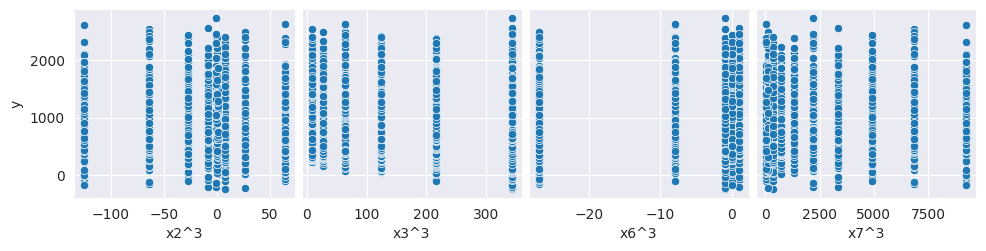

In [256]:
grid = sns.pairplot(df, x_vars=['x2^3', 'x3^3', 'x6^3', 'x7^3'], y_vars=['y'])

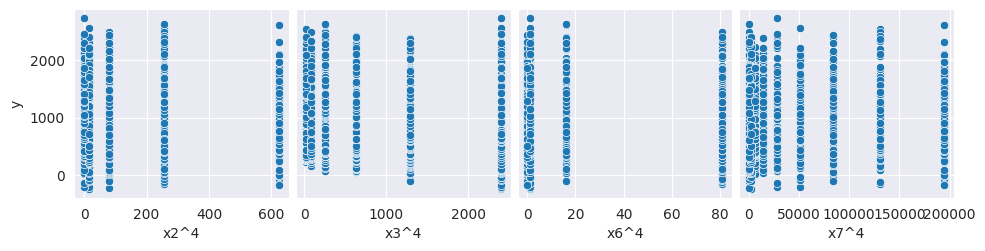

In [257]:
grid = sns.pairplot(df, x_vars=['x2^4', 'x3^4', 'x6^4', 'x7^4'], y_vars=['y'])

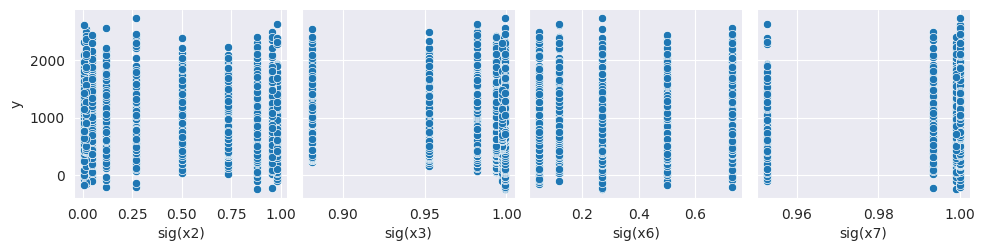

In [258]:
grid = sns.pairplot(df, x_vars=['sig(x2)', 'sig(x3)', 'sig(x6)', 'sig(x7)'], y_vars=['y'])

> Wrzucę to do modelu z SGD i L1, ale nic dobrego z tego nie wróżę

In [259]:
XY_copy = XY.copy()
XY_aug = np.hstack((XY_copy[:,:-1], XY_aug[:,4:]))

In [260]:
from utilz import divide_dataset

T = 10 # numer of iterations

# and some constants
EPOCHS = 100
STEPS_TO_PLOT = 100
# STEPS_TO_PLOT should divide EPOCHS

datasets = []
for i in range(T):
    datasets.append(
        divide_dataset(
            XY_aug,
            fractions_train_val_test=[0.6, 0.2, 0.2]))

In [261]:
from utilz import search_alpha
from linear_regression import SGD_linear_regression
from loss import ols
from gradient import GD_OLS

alphas = [0.0001, 0.001, 0.01, 0.1, 0.5, 1]
search_alpha(
    model=ft.partial(
        SGD_linear_regression,
        grad=GD_OLS,
        batch_size=32,
        epochs=EPOCHS),
    loss=ols,
    datasets=datasets,
    alphas=alphas,
    standardize=True)

Alpha: 0.0001, validation loss 283431.51341591706
Alpha: 0.001, validation loss 15437.592351533609
Alpha: 0.01, validation loss 15239.05795775672
Alpha: 0.1, validation loss 16112.972816189824
Alpha: 0.5, validation loss nan
Alpha: 1, validation loss nan


In [262]:
from utilz import run_linear_regression_model
from linear_regression import SGD_linear_regression
from gradient import GD_OLS
from loss import ols

theta_SGD, loss_SGD, history_SGD, training_SGD =(
run_linear_regression_model(
    ft.partial(
        SGD_linear_regression,
        grad=GD_OLS,
        alpha=0.01,
        batch_size=64,
        epochs=EPOCHS,
        steps=STEPS_TO_PLOT,
        loss=ols),
    loss=ols,
    datasets=datasets,
    standardize=True,
    use_test=True)
)

In [263]:
print(f"Augmented dataset SGD test loss {loss_SGD}")

Augmented dataset SGD test loss 13374.64502660347


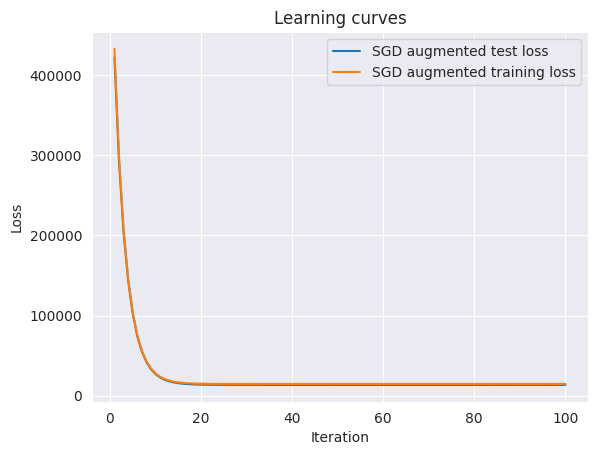

In [264]:
steps = np.arange(1, STEPS_TO_PLOT + 1) * (EPOCHS // STEPS_TO_PLOT)

fig, ax = plt.subplots()
sns.lineplot(x = steps, y = history_SGD, ax = ax, label='SGD augmented test loss')
sns.lineplot(x = steps, y = training_SGD, ax = ax, label='SGD augmented training loss')
ax.set(xlabel='Iteration', ylabel='Loss')
ax.set_title('Learning curves')
plt.legend()

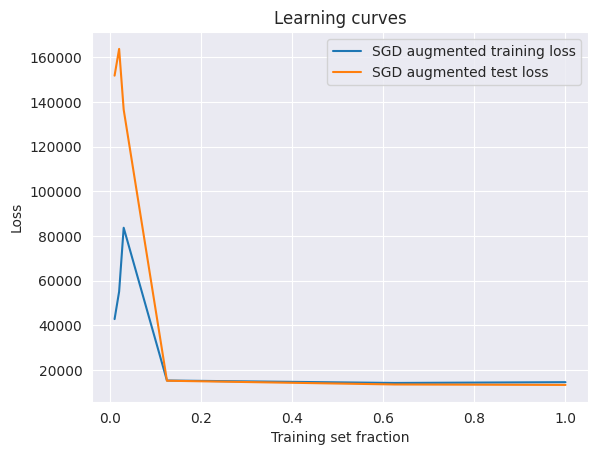

In [265]:
from utilz import learning_curve
from linear_regression import SGD_linear_regression
from gradient import GD_OLS
from loss import ols
training_set_fraction = [0.01, 0.02, 0.03, 0.125, 0.625, 1]

SGD_frac_training_loss, SGD_frac_test_loss = learning_curve(
    model=ft.partial(
        SGD_linear_regression,
        grad=GD_OLS,
        alpha=0.01,
        epochs=EPOCHS,
        batch_size=64,
        steps=1,
        loss=ols),
    loss=ols,
    datasets=datasets,
    training_set_fractions=training_set_fraction)

fig, ax = plt.subplots()
sns.lineplot(x = training_set_fraction, y = SGD_frac_training_loss, ax = ax, label='SGD augmented training loss')
sns.lineplot(x = training_set_fraction, y = SGD_frac_test_loss, ax = ax, label='SGD augmented test loss')
ax.set(xlabel='Training set fraction', ylabel='Loss')
ax.set_title('Learning curves')
plt.legend()

> Ciekawe, że wyszło trochę lepiej \
> I jeszcze na zakończenie L1

In [266]:
from utilz import search_lambdas
from linear_regression import L1_linear_regression
from loss import ols

lambdas = [0, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 2, 4, 8, 16, 256]
search_lambdas(
    model=ft.partial(
        L1_linear_regression,
        epochs=EPOCHS,
        intercept=True,
        steps=STEPS_TO_PLOT,
        loss=ols),
    loss=ols,
    datasets=datasets,
    lambdas=lambdas,
    standardize=True)

Lambda: 0, validation loss 15217.8245805617
Lambda: 1e-05, validation loss 15217.824579438693
Lambda: 0.0001, validation loss 15217.824569331631
Lambda: 0.001, validation loss 15217.824468260991
Lambda: 0.01, validation loss 15217.823457555674
Lambda: 0.1, validation loss 15217.813350615586
Lambda: 1, validation loss 15217.7124269015
Lambda: 2, validation loss 15217.600553430635
Lambda: 4, validation loss 15217.379558967805
Lambda: 8, validation loss 15216.939279857983
Lambda: 16, validation loss 15216.066830098125
Lambda: 256, validation loss 15203.349514971025


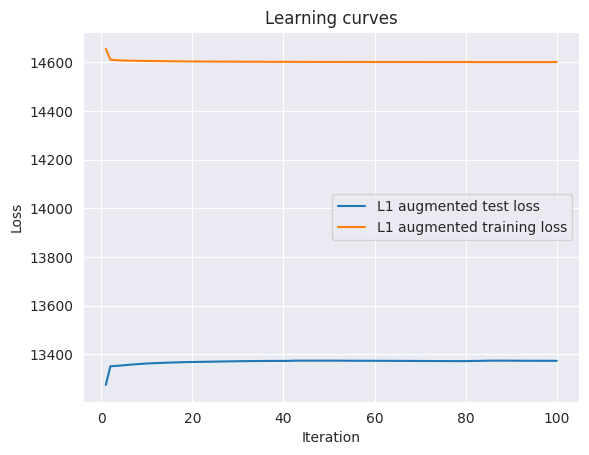

In [267]:
from utilz import run_linear_regression_model
from linear_regression import L1_linear_regression
from loss import ols

theta_L1, loss_L1, history_L1, training_L1 = run_linear_regression_model(
    model=ft.partial(
        L1_linear_regression,
        lambdaa=256,
        epochs=EPOCHS,
        intercept=True,
        steps=STEPS_TO_PLOT,
        loss=ols),
    loss=ols,
    datasets=datasets,
    standardize=True,
    use_test=True)

steps = np.arange(1, STEPS_TO_PLOT + 1) * (EPOCHS // STEPS_TO_PLOT)

fig, ax = plt.subplots()
sns.lineplot(x = steps, y = history_L1, ax = ax, label='L1 augmented test loss')
sns.lineplot(x = steps, y = training_L1, ax = ax, label='L1 augmented training loss')
ax.set(xlabel='Iteration', ylabel='Loss')
ax.set_title('Learning curves')
plt.legend()

> Te wykresy mnie zawsze zaskakują <3

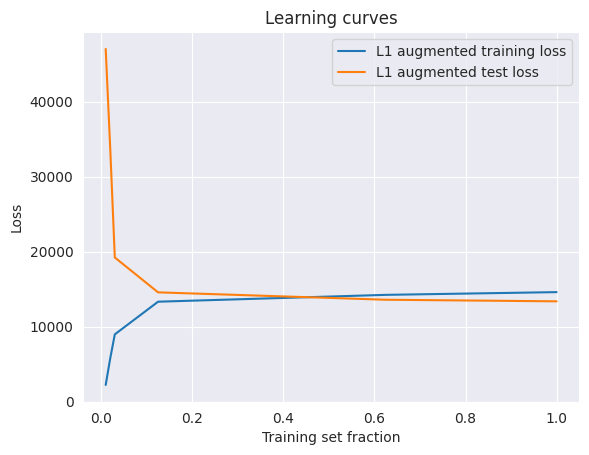

In [268]:
from utilz import learning_curve
from linear_regression import L1_linear_regression
from loss import ols
training_set_fraction = [0.01, 0.02, 0.03, 0.125, 0.625, 1]

L1_frac_training_loss, L1_frac_test_loss = learning_curve(
    model=ft.partial(
        L1_linear_regression,
        lambdaa=256,
        epochs=EPOCHS,
        intercept=True,
        steps=1,
        loss=ols),
    loss=ols,
    datasets=datasets,
    training_set_fractions=training_set_fraction)

fig, ax = plt.subplots()
sns.lineplot(x = training_set_fraction, y = L1_frac_training_loss, ax = ax, label='L1 augmented training loss')
sns.lineplot(x = training_set_fraction, y = L1_frac_test_loss, ax = ax, label='L1 augmented test loss')
ax.set(xlabel='Training set fraction', ylabel='Loss')
ax.set_title('Learning curves')
plt.legend()

> Ewidentnie regularyzacja działa

In [269]:
print(f"Augmented dataset test loss L1: {loss_L1}")
print(f"Augmented dataset test loss SGD: {loss_SGD}")

Augmented dataset test loss L1: 13373.628554380542
Augmented dataset test loss SGD: 13374.64502660347


> THE END

> BONUS piękno SGD

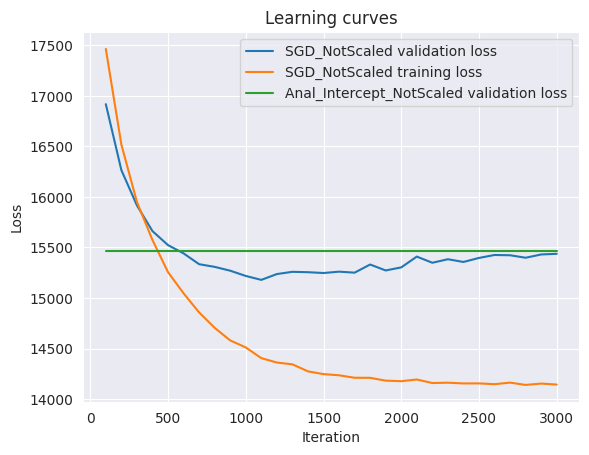

In [270]:
from utilz import run_linear_regression_model
from linear_regression import SGD_linear_regression
from gradient import GD_OLS
from loss import ols
from utilz import divide_dataset

T = 10 # numer of iterations

# and some constants
EPOCHS = 3000
STEPS_TO_PLOT = 30
# STEPS_TO_PLOT should divide EPOCHS

datasets = []
for i in range(T):
    datasets.append(
        divide_dataset(
            XY.copy(),
            fractions_train_val_test=[0.6, 0.2, 0.2]))

theta_SGD_NotScaled, loss_SGD_NotScaled, history_SGD_NotScaled, training_SGD_NotScaled =(
run_linear_regression_model(
    ft.partial(
        SGD_linear_regression,
        grad=GD_OLS,
        alpha=0.0001,
        batch_size=64,
        epochs=EPOCHS,
        steps=STEPS_TO_PLOT,
        loss=ols),
    loss=ols,
    datasets=datasets,
    standardize=False,
    use_test=False)
)

steps = np.arange(1, STEPS_TO_PLOT + 1) * (EPOCHS // STEPS_TO_PLOT)

fig, ax = plt.subplots()
sns.lineplot(x = steps, y = history_SGD_NotScaled, ax = ax, label='SGD_NotScaled validation loss')
sns.lineplot(x = steps, y = training_SGD_NotScaled, ax = ax, label='SGD_NotScaled training loss')
sns.lineplot(x = steps, y = history_Anal_Intercept_NotScaled, ax = ax, label='Anal_Intercept_NotScaled validation loss')
ax.set(xlabel='Iteration', ylabel='Loss')
ax.set_title('Learning curves')
plt.legend()
